In [1]:
import time,csv
import numpy as np

In [2]:
from TDD.TDD import global_norm
# from TDD.TDD import TDD
# def global_norm(tdd):
#     node=tdd.node
#     weight=tdd.weight

#     if node.key==-1:
#         return tdd

#     h=weight
#     tdd_list=[]
#     for i in range (len(node.out_weight)):
#         tdd_list.append(TDD(node.successor[i]))
#         tdd_list[i].weight=h*node.out_weight[i]
#         tdd_list[i]=global_norm(tdd_list[i])

#     from TDD.TDD import normalize
#     new_tdd=normalize(node.key,tdd_list)
#     return new_tdd

In [3]:
from TDD.TDD import Ini_TDD
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num

def STDD_simulation(cir, Benchmark_Name=None, unique_table_reset=True, add_inputs_list=None, optimizer=None):
    n=get_real_qubit_num(cir)
    tn,indices=cir_2_tn(cir)
    #add y indices
    indices2=[]
    for i, item in enumerate(indices):
        indices2.append(item)
        if item[0]=='y':
            num=int(item.replace('y',''))
            # indices2.append('z%i'%num)
    t_start=time.time()
    #add sin cos indices
    sin_str=set()
    cos_str=set()
    for tensor in tn.tensors:
        for element in tensor.data.flatten(): 
            from sympy.core.expr import Expr 
            if isinstance(element,Expr):
                for symbol in element.free_symbols:
                    sin_str.add('sin('+str(symbol)+')')
                    cos_str.add('cos('+str(symbol)+')')
    sin_str=list(sin_str)
    sin_str.sort()
    cos_str=list(cos_str)
    cos_str.sort()
    sym_str=[]
    for i in range(len(sin_str)):
        sym_str.append(sin_str[i])
        sym_str.append(cos_str[i])

    # TDD process
    Ini_TDD(indices2,sym_str,type='TrDD',unique_table_reset=unique_table_reset)

    if add_inputs_list:
        from TDD.TDD_Q import add_inputs
        # add_inputs(tn,[0]*n,n)
        add_inputs(tn,add_inputs_list)

    start_cont=time.time()-t_start
    print('start cont ',start_cont)
    tdd, Max_node_num=tn.cont(optimizer=optimizer,max_node=True)
    cont_time=time.time()-start_cont-t_start
    print('cont complete',cont_time)

    from TDD.TDD import get_unique_table_num as gu1
    from TDD.TrDD.BDD import get_unique_table_num as gu2
    output_dict={'Benchmark Name':Benchmark_Name,
            'Parameter num': len(sin_str),
            'Qubit num.':tn.qubits_num,
            'Gate num.':len(cir.data),
            'Time':cont_time,
            'Node num. max':Max_node_num,
            'Node num. final':tdd.node_number(),
            'gu1':gu1(),
            'gu2':gu2()
    }
    return tdd, output_dict

In [4]:
def STDD_verify(cir, cir2, Benchmark_Name=None, unique_table_reset=True, add_inputs_list=None, optimizer=None):
    n=get_real_qubit_num(cir)
    tn,indices=cir_2_tn(cir)
    tn2, indices3 =cir_2_tn(cir2.inverse())
    #add y indices
    indices2=[]
    for i, item in enumerate(indices):
        indices2.append(item)
        if item[0]=='y':
            num=int(item.replace('y',''))
            # indices2.append('z%i'%num)
    t_start=time.time()
    #add sin cos indices
    sin_str=set()
    cos_str=set()
    for tensor in tn.tensors:
        for element in tensor.data.flatten(): 
            from sympy.core.expr import Expr 
            if isinstance(element,Expr):
                for symbol in element.free_symbols:
                    sin_str.add('sin('+str(symbol)+')')
                    cos_str.add('cos('+str(symbol)+')')
    sin_str=list(sin_str)
    sin_str.sort()
    cos_str=list(cos_str)
    cos_str.sort()
    sym_str=[]
    for i in range(len(sin_str)):
        sym_str.append(sin_str[i])
        sym_str.append(cos_str[i])

    # TDD process
    Ini_TDD(indices2,sym_str,type='TrDD',unique_table_reset=unique_table_reset)

    if add_inputs_list:
        from TDD.TDD_Q import add_inputs
        # add_inputs(tn,[0]*n,n)
        add_inputs(tn,add_inputs_list)

    start_cont=time.time()-t_start
    print('start cont ',start_cont)
    # tdd, Max_node_num=tn.cont(optimizer=optimizer,max_node=True)
    def cont2(tn,tn2):
        from TDD.TDD import cont, get_identity_tdd
        max_node_num=0
        tdd=get_identity_tdd()

        l1=len(tn.tensors)
        l2=len(tn2.tensors)
        l=min(l1,l2)
        d=l1-l2
        for i in range(l):
            ts1=tn.tensors[-(i+1)]
            ts2=tn.tensors[i]
            tdd1=ts1.tdd()
            tdd2=ts2.tdd()

            tdd=cont(tdd1,tdd)
            max_node_num=max(max_node_num,tdd.node_number())
            tdd=cont(tdd,tdd2)
            max_node_num=max(max_node_num,tdd.node_number())
        if d>0:
            for i in range(d):
                ts1=tn.tensors(-(i+l+1))
                tdd1=ts1.tdd()
                tdd=cont(tdd1,tdd)
                max_node_num=max(max_node_num,tdd.node_number())
        if d<0:
            for i in range(d):
                ts2=tn.tensors(i+l)
                tdd2=ts2.tdd()
                tdd=cont(tdd,tdd2)
                max_node_num=max(max_node_num,tdd.node_number())

        return tdd, max_node_num

    tdd, Max_node_num= cont2(tn,tn2)
    cont_time=time.time()-start_cont-t_start
    print('cont complete',cont_time)

    from TDD.TDD import get_unique_table_num as gu1
    from TDD.TrDD.BDD import get_unique_table_num as gu2
    output_dict={'Benchmark Name':Benchmark_Name,
            'Parameter num': len(sin_str),
            'Qubit num.':tn.qubits_num,
            'Gate num.':len(cir.data),
            'Time':cont_time,
            'Node num. max':Max_node_num,
            'Node num. final':tdd.node_number(),
            'gu1':gu1(),
            'gu2':gu2()
    }
    return tdd, output_dict

In [5]:
def verify(tdd1,tdd2):
    start_time= time.time()
    # equivalent without global_norm
    if tdd1==tdd2:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"equivalent"}
        print(output_dict)
        return output_dict
    elif tdd1.node==tdd2.node:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"equivalent_up_to_global_phase"}
        print(output_dict)
        return output_dict
    tddn=global_norm(tdd1)
    tddn2=global_norm(tdd2)
    # equivalent with global_norm
    if tddn==tddn2:
        output_dict={"check_time":check_time,"equivalence":"equivalent"}
        print('global_norm',output_dict)
        return output_dict
    elif tddn.node==tdd2.node:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"equivalent_up_to_global_phase"}
        print('global_norm',output_dict)
        return output_dict
    # not equivalent 
    else:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"not_equivalent"}
        print(output_dict)
        return output_dict

In [6]:
from qiskit import transpile
from qiskit.circuit import Parameter, QuantumCircuit, library

def circuit_generator(qubit_num=1,reps=1,function_name='TwoLocal'
                    ,basis_gates1=['id', 'rz', 'sx', 'x', 'cx']
                    ,basis_gates2=['h','ry','rz','cx']):

    if function_name=='TwoLocal':
        cir = library.TwoLocal(qubit_num, ['ry'],'cx', entanglement='circular', reps=reps)
    if function_name=='ExcitationPreserving':
        cir = library.ExcitationPreserving(qubit_num, mode='fsim', entanglement='full', reps=reps)
    if function_name=='RealAmplitudes':
        cir = library.TwoLocal(qubit_num, ['rx'],'cx', entanglement='full', reps=reps)
    if function_name=='EfficientSU2':
        cir = library.TwoLocal(qubit_num, ['rx','h'],'cx', entanglement='circular', reps=reps)

    cir=transpile(cir,basis_gates=basis_gates1)
    cir2=transpile(cir,basis_gates=basis_gates2)

    return cir,cir2,'%s_%i_%i'%(function_name,qubit_num,reps)

In [7]:
cir,cir2,data=circuit_generator(qubit_num=2,reps=1, function_name='RealAmplitudes')

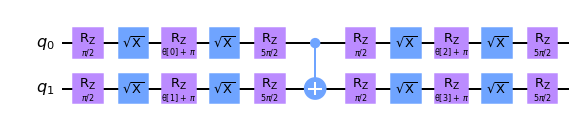

In [8]:
cir.draw('mpl')

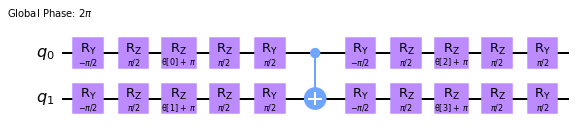

In [9]:
cir2.draw('mpl')

In [10]:
def experiment(qubit_num=2,reps=1,function='RealAmplitudes', optimizer=None, file_name=None):
        cir1,cir2,circuit_nam=circuit_generator(qubit_num=qubit_num,reps=reps,function_name=function)
        tdd1,output_dict1=STDD_simulation(cir1, unique_table_reset=True, optimizer=optimizer)
        tdd2,output_dict2=STDD_simulation(cir2, unique_table_reset=False, optimizer=optimizer)
        output_dict3=verify(tdd1,tdd2)
        if file_name:
                with open(file_name, 'a', newline='') as csvfile:
                        fieldnames = ['Benchmark Name','Parameter num.','Qubit num.'
                                ,'Gate num._1','Time_1','Node num. max_1','Node num. final_1','gu1_1','gu2_1'
                                ,'Gate num._2','Time_2','Node num. max_2','Node num. final_2','gu1_2','gu2_2'
                                ,'Check_time','Totol_time','Equivalent']
                        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                        writer.writerow({'Benchmark Name':circuit_nam,'Parameter num.':output_dict1['Parameter num'],'Qubit num.':output_dict1['Qubit num.']
                        ,'Gate num._1':output_dict1['Gate num.'],'Time_1':output_dict1['Time'],'Node num. max_1':output_dict1['Node num. max']
                        ,'Node num. final_1':output_dict1['Node num. final'],'gu1_1':output_dict1['gu1'],'gu2_1':output_dict1['gu2']
                        ,'Gate num._2':output_dict2['Gate num.'],'Time_2':output_dict2['Time'],'Node num. max_2':output_dict2['Node num. max']
                        ,'Node num. final_2':output_dict2['Node num. final'],'gu1_2':output_dict2['gu1'],'gu2_2':output_dict2['gu2']
                        ,'Check_time':output_dict3['check_time'],'Totol_time':output_dict1['Time']+output_dict2['Time']+output_dict3['check_time']
                        ,'Equivalent':output_dict3['equivalence']})
        return {'Benchmark Name':circuit_nam,'Parameter num.':output_dict1['Parameter num'],'Qubit num.':output_dict1['Qubit num.']
                ,'Gate num._1':output_dict1['Gate num.'],'Time_1':output_dict1['Time'],'Node num. max_1':output_dict1['Node num. max']
                ,'Node num. final_1':output_dict1['Node num. final'],'gu1_1':output_dict1['gu1'],'gu2_1':output_dict1['gu2']
                ,'Gate num._2':output_dict2['Gate num.'],'Time_2':output_dict2['Time'],'Node num. max_2':output_dict2['Node num. max']
                ,'Node num. final_2':output_dict2['Node num. final'],'gu1_2':output_dict2['gu1'],'gu2_2':output_dict2['gu2']
                ,'Check_time':output_dict3['check_time'],'Totol_time':output_dict1['Time']+output_dict2['Time']+output_dict3['check_time']
                ,'Equivalent':output_dict3['equivalence']}



In [11]:
tdd1,output_dict1=STDD_simulation(cir, unique_table_reset=True)

start cont  0.0019311904907226562
cont complete 0.0280611515045166


In [12]:
# tdd1.show()

In [13]:
experiment(qubit_num=2,reps=1,function='RealAmplitudes')

start cont  0.0007596015930175781
cont complete 0.025185108184814453
start cont  0.0005524158477783203
cont complete 0.0164794921875
{'check_time': 5.245208740234375e-06, 'equivalence': 'equivalent'}


{'Benchmark Name': 'RealAmplitudes_2_1',
 'Parameter num.': 4,
 'Qubit num.': 2,
 'Gate num._1': 21,
 'Time_1': 0.025185108184814453,
 'Node num. max_1': 12,
 'Node num. final_1': 12,
 'gu1_1': 148,
 'gu2_1': 101,
 'Gate num._2': 21,
 'Time_2': 0.0164794921875,
 'Node num. max_2': 12,
 'Node num. final_2': 12,
 'gu1_2': 192,
 'gu2_2': 101,
 'Check_time': 5.245208740234375e-06,
 'Totol_time': 0.04166984558105469,
 'Equivalent': 'equivalent'}

In [14]:
tdd, output_dict=STDD_verify(cir, cir2)
output_dict

start cont  0.0009353160858154297
cont complete 0.2233564853668213


{'Benchmark Name': None,
 'Parameter num': 4,
 'Qubit num.': 2,
 'Gate num.': 21,
 'Time': 0.2233564853668213,
 'Node num. max': 40,
 'Node num. final': 1,
 'gu1': 381,
 'gu2': 332}

In [15]:
tdd.weight

64*(((cos(θ3)**2 - 1/2)*cos(θ2)**2 + (-1/2 + 117756934401283*I/1000000000000000000000000000000)*(cos(θ3)**2 - 1/2))*cos(θ1)**2 + (-1/2 + 12266347333467*I/156250000000000000000000000000)*((cos(θ3)**2 - 1/2)*cos(θ2)**2 + (-1/2 + 117756934401283*I/1000000000000000000000000000000)*(cos(θ3)**2 - 1/2)) - (sin(θ3)*cos(θ2)**2*cos(θ3) + (-1/2 + 117756934401283*I/1000000000000000000000000000000)*sin(θ3)*cos(θ3))*sin(θ1)*cos(θ1))*cos(θ0)**2 + 64*(-1/2 + 36799042000401*I/1250000000000000000000000000000)*(((cos(θ3)**2 - 1/2)*cos(θ2)**2 + (-1/2 + 117756934401283*I/1000000000000000000000000000000)*(cos(θ3)**2 - 1/2))*cos(θ1)**2 + (-1/2 + 12266347333467*I/156250000000000000000000000000)*((cos(θ3)**2 - 1/2)*cos(θ2)**2 + (-1/2 + 117756934401283*I/1000000000000000000000000000000)*(cos(θ3)**2 - 1/2)) - (sin(θ3)*cos(θ2)**2*cos(θ3) + (-1/2 + 117756934401283*I/1000000000000000000000000000000)*sin(θ3)*cos(θ3))*sin(θ1)*cos(θ1)) + 64*I*((cos(θ3)**2 - 1/2)*sin(θ1)*sin(θ2)*cos(θ1)*cos(θ2) + sin(θ2)*sin(θ3)*cos(θ1

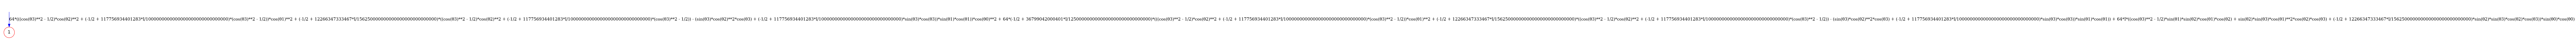

In [16]:
tdd.show()

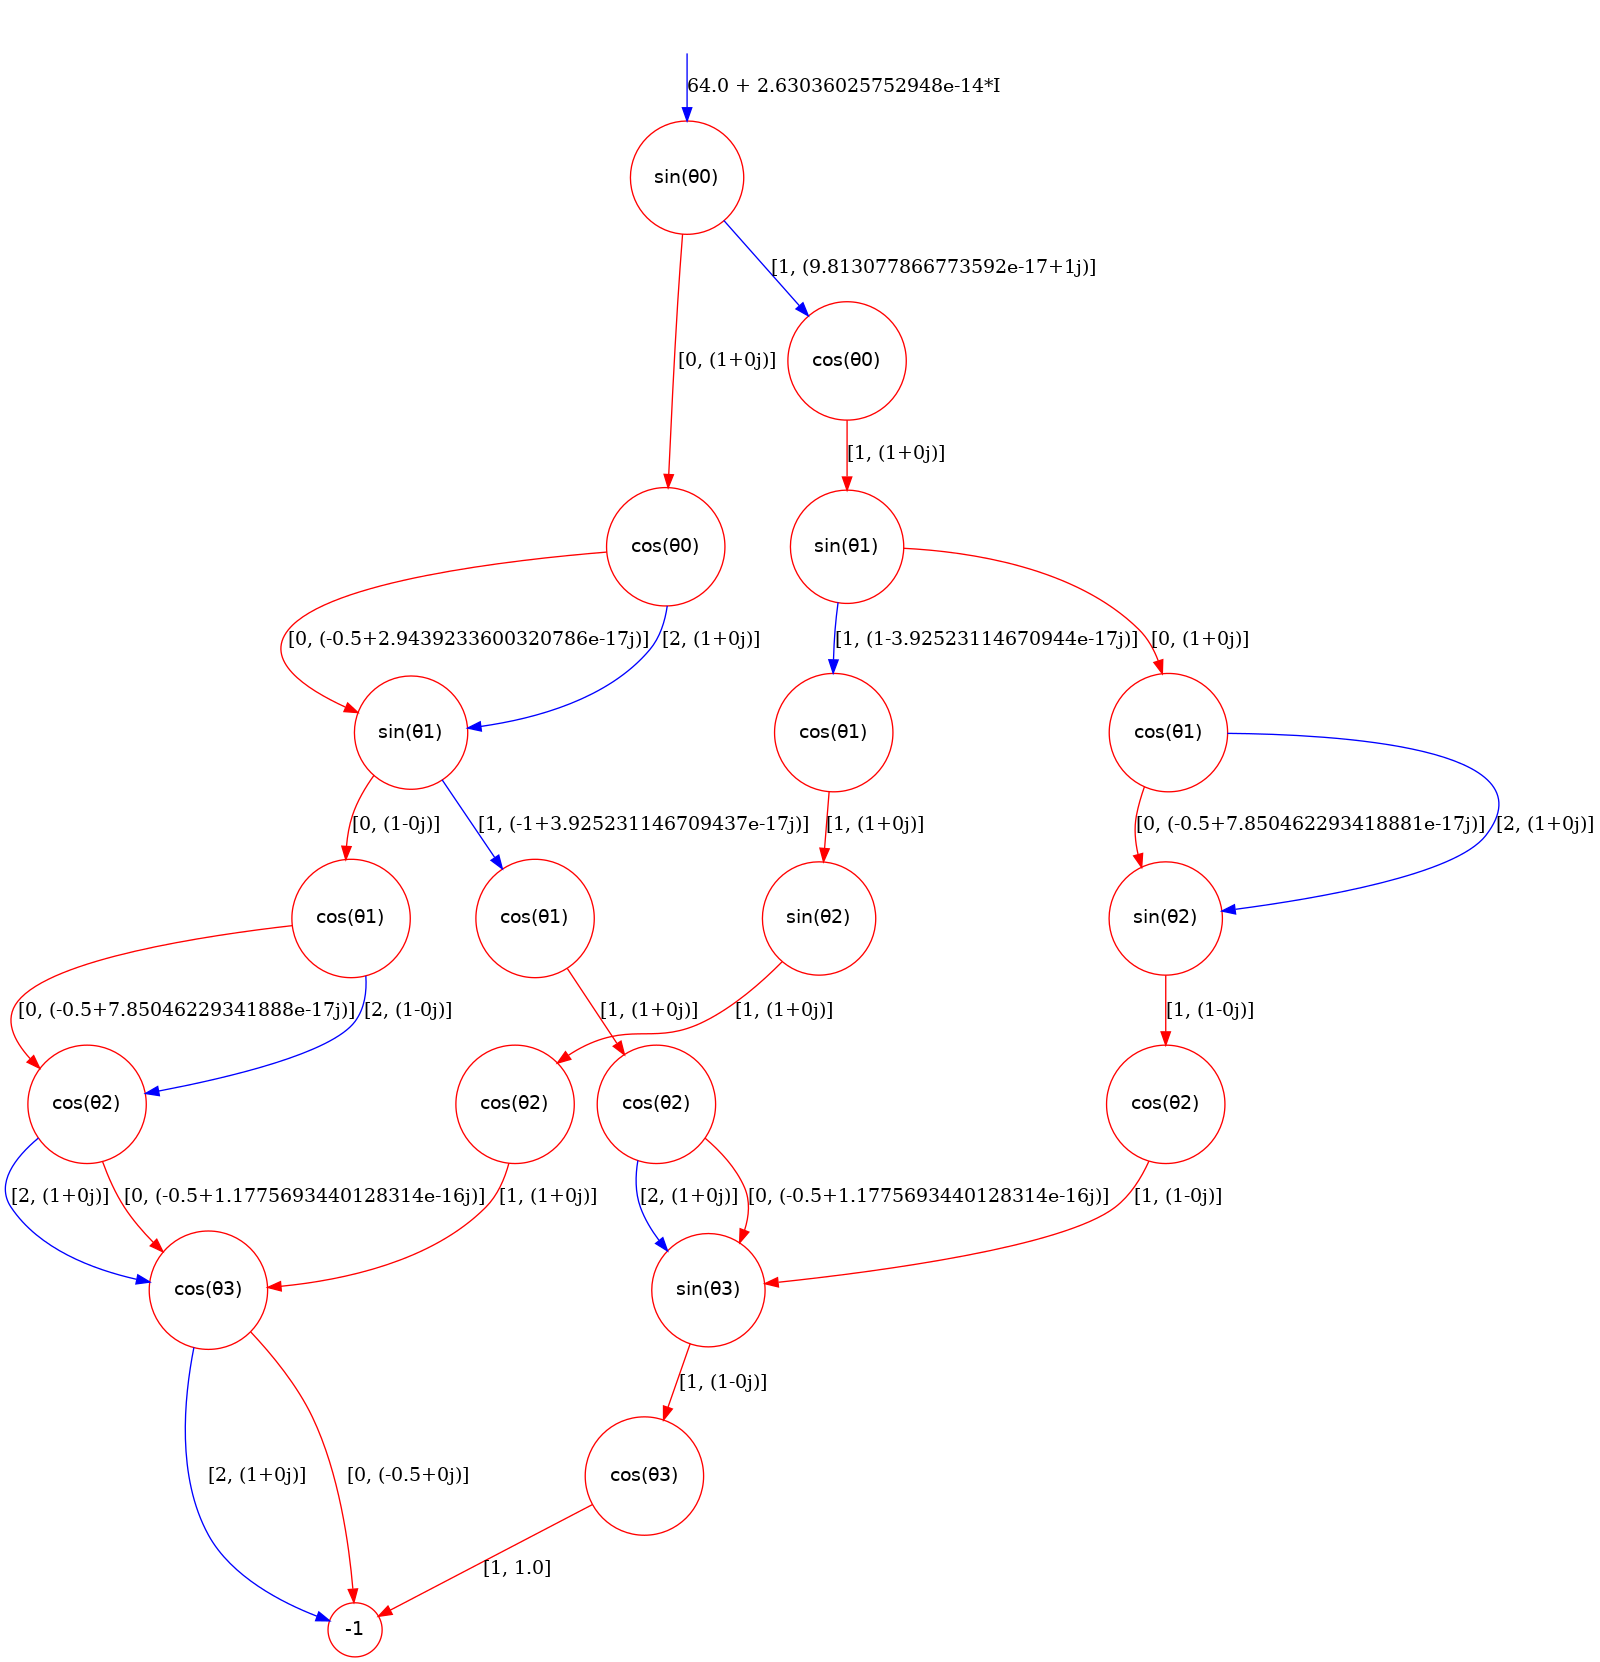

In [17]:
tdd.weight.show()

In [18]:
# function_list=['RealAmplitudes','EfficientSU2']
# experiment_setup=[(5,3)]
    
# for qubit_num,reps in experiment_setup:
#     for function in function_list:
#             experiment(qubit_num=qubit_num, reps=reps, function=function, optimizer=None, file_name='STDD benchmark.csv')
        

In [19]:

# with open('STDD cir_partition2 benchmark.csv', 'w', newline='') as csvfile:
#     fieldnames=['Benchmark Name','Parameter num.','Qubit num.'
# ,'Gate num._1','Time_1','Node num. max_1','Node num. final_1','gu1_1','gu2_1'
# ,'Gate num._2','Time_2','Node num. max_2','Node num. final_2','gu1_2','gu2_2'
# ,'Check_time','Totol_time','Equivalent']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()
